## Chapter 10: Introduction to Nonlinear Learning

# 10.5  Features, functions, and nonlinear unsupervised learning

In this Section we introduce the general framework of nonlinear unsupervised learning, with special emphasis on the Autoencoder from Section 8.3. In future Chapters we will look at particular examples of how to extend other unsupervised methods such as K-Means (introduced in Section 8.6).

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import unsupervised_library as unlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
optimizers = optlib.optimizers

basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np
import numpy as npo

# import timer
from datetime import datetime 
import copy

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import matplotlib.pyplot as plt
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

## 10.5.1  Modeling principles of the linear Autoencoder

In Section 8.3 we discussed the PCA Autoencoder, the fundamental cost function for PCA that leads to the classic orthogonal PCA solution (described in Section 8.4).  The Autoencoder cost function  

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

is parameterized by the $N\times K$ matrix $\mathbf{C}$ that will act as our recovered basis upon minimization.  Here our model is the entire computation 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{C}\right) = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}.
\end{equation}

The goal in minimizing this quantity is to tune the parameters of $\mathbf{C}$ to learn a model that is *as close to the identity as possible* i.e., so that the following approximation holds as well as possible

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{C}\right) = \mathbf{C}\mathbf{C}^T \approx \mathbf{I}_{N\times N}.
\end{equation}

Note how we can decompose the model above into an *encoding* and *decoding* modeling sequence.  We have our encoder model $\text{model}_e$

\begin{equation}
\text{model}_{\text{e}}\left(\mathbf{x},\mathbf{C}\right) = \mathbf{C}^T \mathbf{x}
\end{equation}

which takes in $N$ dimensional input and whose output is $K$ dimensional, and our decoder model $\text{model}_{\text{d}}$ which takes a similar algebraic form

\begin{equation}
\text{model}_{\text{d}}\left(\mathbf{v},\mathbf{C}\right) = \mathbf{C} \mathbf{v}
\end{equation}

but that intakes $K$ dimensional input and whose output is $N$ dimensional.

In this notation our general linear Autoencoder model is then the *composition of these two individual models* as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{C}\right)  = \text{model}_{\text{d}}\left(\,\text{model}_{\text{e}}\left(\mathbf{x},\mathbf{C}\right),\mathbf{C}\right) 
\end{equation}

## 10.5.2  Modeling principles of the nonlinear Autoencoder

Just as we discussed in the previous Sections, where we described how to extend linear regression and classification to the general nonlinear case, here the fact the encoder and decoder above are *linear* does not reflect a limitation of the Autoencoder framework but simply *our own modeling choice*.  Nothing about the Autoencoder framework itself limits us to using *linear* encoding/decoding models, and thus prevents us from extending the idea in order to uncover the best *nonlinear* manifold for a given set of input data.  To get at potential nonlinearity we simply replace the linear encoder / decoder models above with general nonlinear versions of the form we have seen previously

\begin{equation}
\text{model}_{\text{e}}\left(\mathbf{x},\Theta_e\right) = w^e_0 + f^e_1\left(\mathbf{x}\right){w}^e_{1} +  f^e_2\left(\mathbf{x}\right){w}^e_{2} + \cdots + f^e_{B_e}\left(\mathbf{x}\right)w^e_{B_e} \\ 
\text{model}_{\text{d}}\left(\mathbf{x},\Theta_d\right) = w^d_0 + f^d_1\left(\mathbf{v}\right){w}^d_{1} +  f^d_2\left(\mathbf{v}\right){w}^d_{2} + \cdots + f^d_{B_d}\left(\mathbf{v}\right)w^d_{B_d}. \\ 
\end{equation}

Here $f^e_1,\,f^e_2,\,...\,f^e_{B_e}$ are nonlinear feature transformations that take in $N$ dimensional input / whose output is $K$ dimensional and $\Theta_e$ is the parameter set for the encoding model containing internal weights of the combination $w^e_0$ through $w^e_{B_e}$ as well as any internal parameters of the feature transformations, and likewise for the feature transformations $f^d_1,\,f^d_2,\,...\,f^d_{B_d}$ which intake $K$ dimensional input / whose output is $N$ dimensional and $\Theta_d$ for the decoder model.   Regardless of their forms composing the two gives us a general nonlinear model for the Autoencoder as 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \text{model}_{\text{d}}\left(\text{model}_{\text{e}}\left(\mathbf{x},\Theta_e\right),\Theta_d\right)  
\end{equation}

where the parameter $\Theta$ set contains all parameters of $\Theta_e$ and $\Theta_d$.

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/10_5.png' width="85%"  alt=""/>
</p>
<figcaption> <strong>Figure:</strong> <em> 
(left) Linear autoencoder illustrated. Here the encoder is defined by the linear model $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}$. (right) Nonlinear autoencoder is achieved by injecting nonlinear feature transformations into our model. Here the encoder is a nonlinear curve defined by $\mathring{\mathbf{f}}_{\,}^T\mathbf{w}^{\,}$.
</em>
</figcaption>
</figure>

As with the nonlinear supervised framework detailed previously, here our challenge is to determine precisely what form each of these feature transformations should take, how many to use, etc.,   In analogy to the linear case, here we aim to chose the feature transformations and tune the parameters of $\Theta$ properly to learn an *identity function* i.e., so that the approximation

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right)  \approx \mathbf{I}_{N\times N}
\end{equation}

holds as well as possible.  

For any given choice of feature transformations we can tune the parameters of $\Theta$ by minimizing the Autoencoder / Least Squares cost

\begin{equation}
g\left(\Theta\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \,\text{model}\left(\mathbf{x},\Theta\right) - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

## 10.5.3 A feature engineering example

Given that both encoder and decoder models contain nonlinear features that must be determined, and the compositional way in which the model is formed, determining features properly ourselves by e.g., visual analysis of a dataset (feature engineering) for the Autoencoder can be quite tricky even for a simple example, which we provide here.

#### <span style="color:#a50e3e;">Example 1. </span> Finding a circular subspace via the Autoencoder

In this example we use a simulated dataset of $P=20$ two-dimensional data points to learn a circular manifold via our nonlinear Autoencoder scheme. The Python cell below plots the data - which as you can see - has an almost circular shape but not all of the data points fall precisely on a circle (due to noise).

<IPython.core.display.Javascript object>


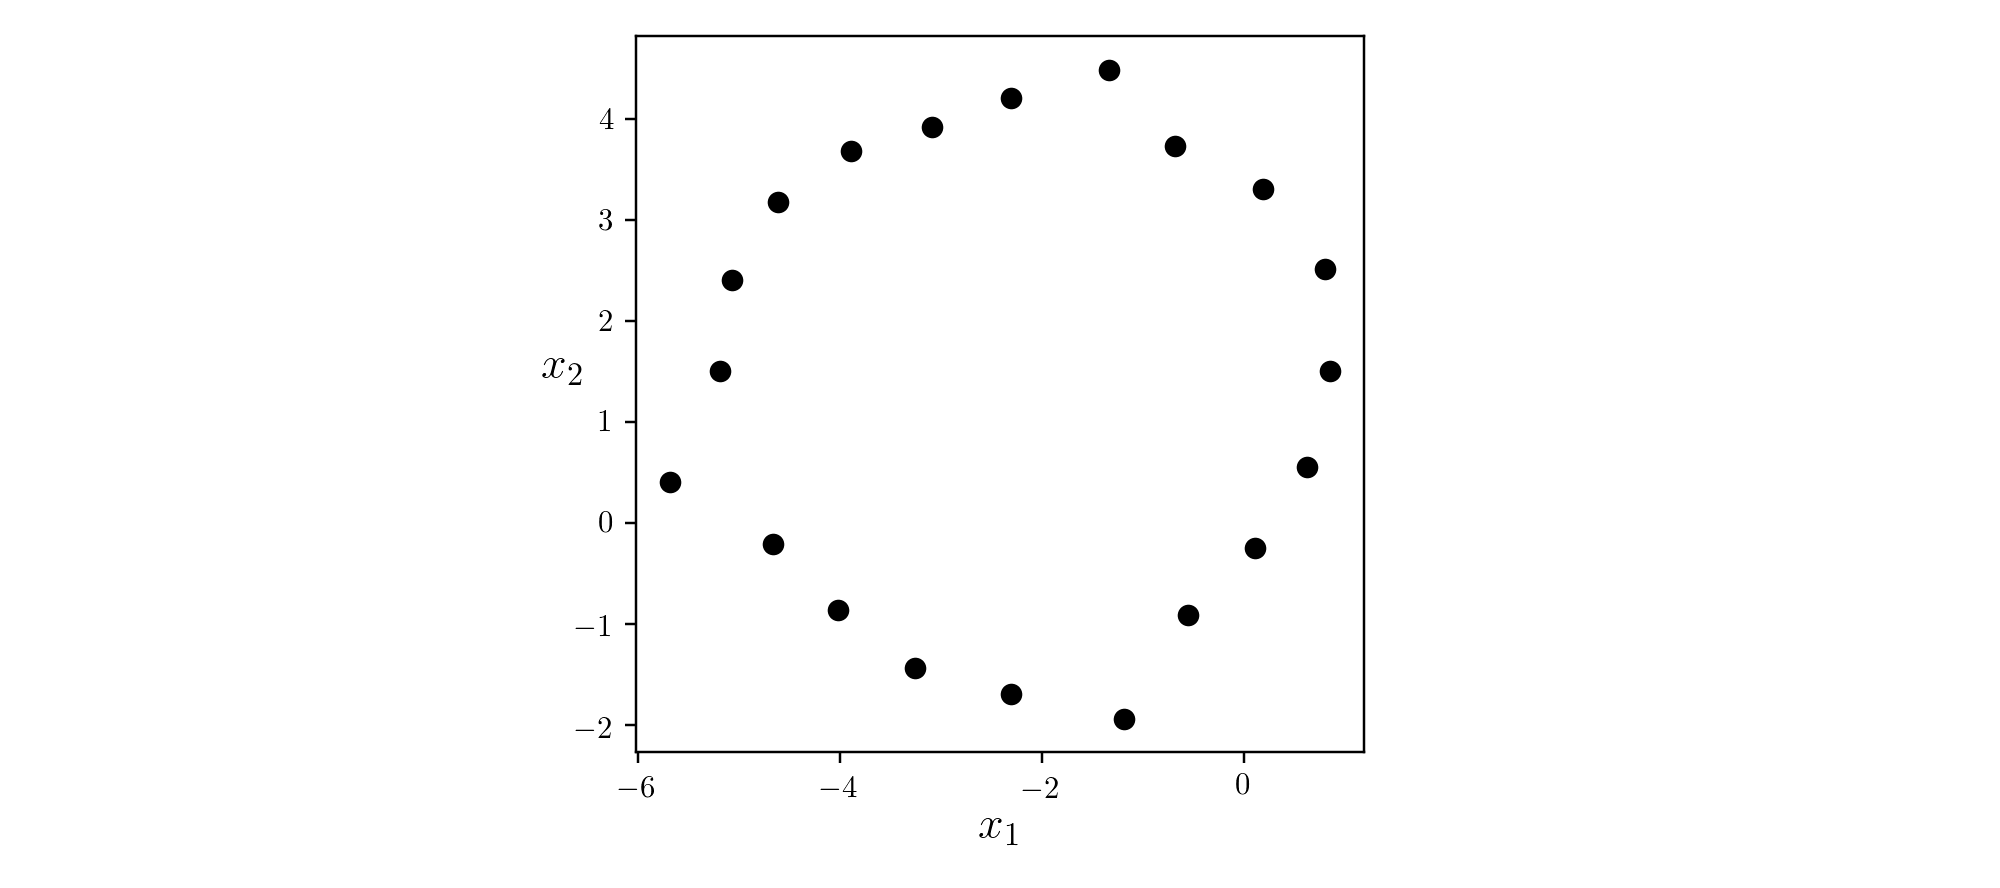

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# import data
X = np.loadtxt(datapath + 'circle_data.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

A general circle in 2-d, as shown in the left panel of Figure 1, can be characterized using its center point $\mathbf{w}$ and radius $r$. Subtracting off $\mathbf{w}$ from any point $\mathbf{x}_p$ on the circle then centers the data at origin, as shown in the right panel of Figure 1.

<figure>
<img src="../../mlrefined_images/unsupervised_images/autoencoder_circle.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left) A circle in two dimensions is characterized by its center $\mathbf{w}$ and its radius $r$. (right) when centered at the origin, any point on the circle can be represented using the angle created between its connector to the origin and the horizontal axis. </em>
</figcaption>
</figure>

Once centered, any two-dimensional data point $\mathbf{x}_p-\mathbf{w}$ on the circle can be encoded as the (scalar) angle $\theta_p$ between the line segment connecting it to the origin and the horizontal axis. Mathematically speaking we have

\begin{equation}
\theta_p=\text{arctan}\left(\frac{x_
{p,2}-w_2}{x_{p,1}-w_1}\right)
\end{equation}

To design the decoder, beginning with $\theta_p$, we can reconstruct $\mathbf{x}_p$ as

\begin{equation}
\mathbf{x}_p=\left[\begin{array}{c}
r_1\,\text{cos}(\theta_p)+w_1\\
r_2\,\text{sin}(\theta_p)+w_2
\end{array}\right]
\end{equation}

Using gradient descent we can now minimize the Autoencoder cost, finding the optimal encoder/decoder parameters for this dataset.

<IPython.core.display.Javascript object>


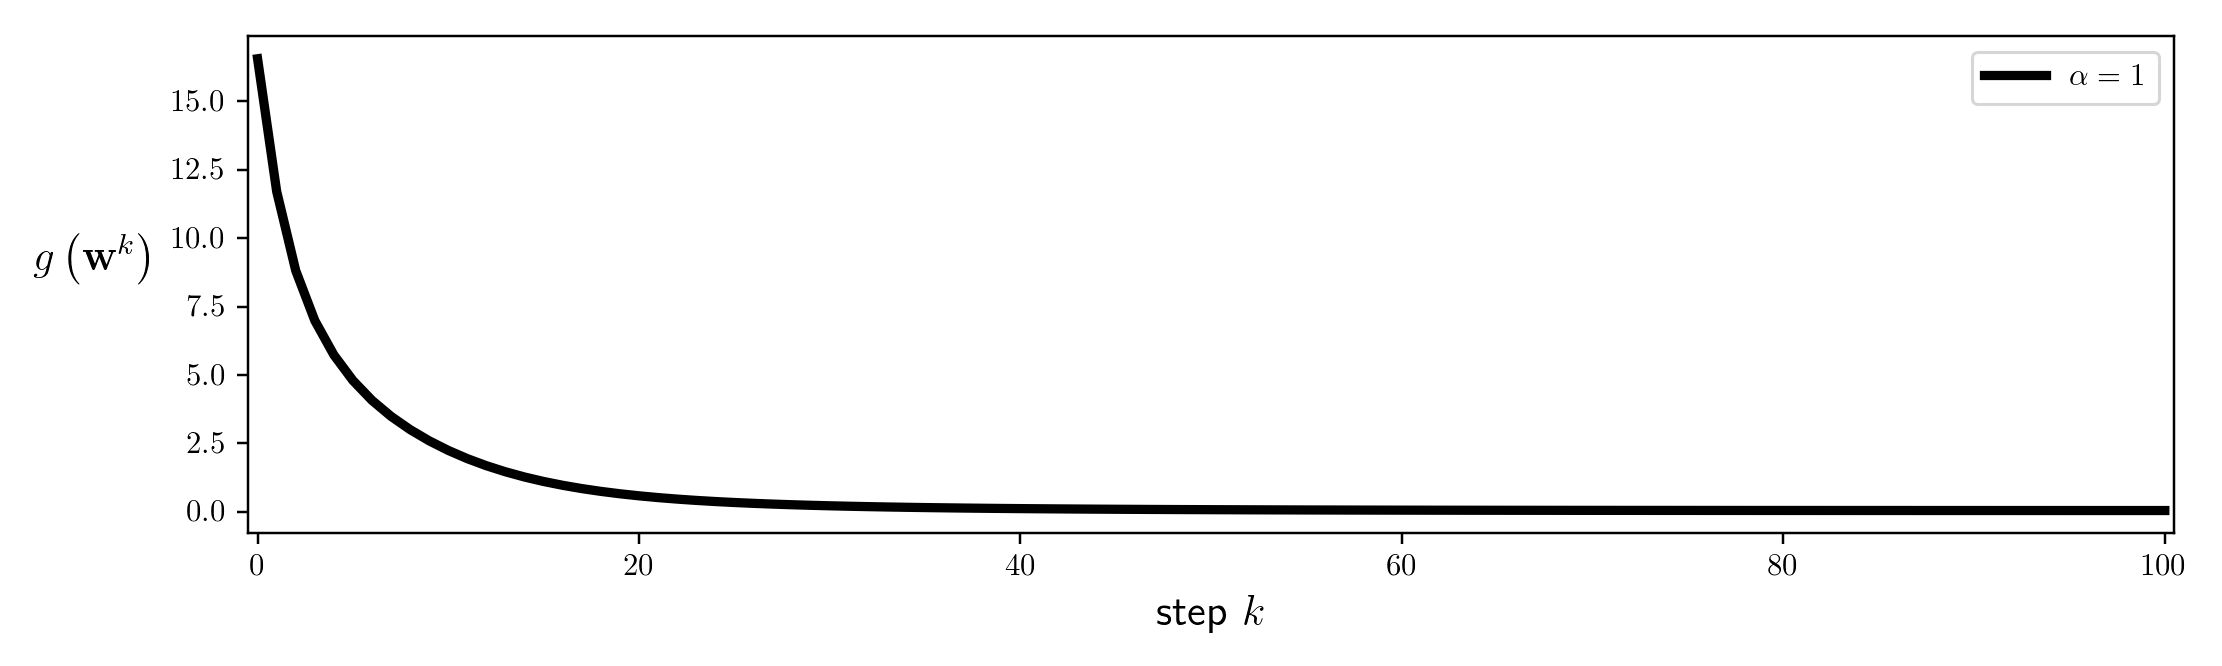

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# custom arctan function
def my_arctan(x1,x2):
    v = x2/x1
    if x1 > 0:
        return np.arctan(v)
    elif x1 < 0 and x2 >= 0:
        return np.arctan(v) + np.pi
    elif x1 < 0 and x2 < 0:
        return np.arctan(v) - np.pi
    elif x1==0 and x2 > 0:
        return np.pi*0.5
    elif x1==0 and x2 < 0:
        return -np.pi*0.5  
    
### autoencoder functionality ###
# autoencoder 
def autoencoder(w):
    cost = np.sum((model(X,w) - X)**2)
    return cost/float(X.shape[1])

# a general model wrapping up our encoder/decoder
def model(X,w):
    # encode the input
    v = encoder(X,w[0])
    
    # decode the encoding
    a = decoder(v,w[1])
    return a

# encoder
def encoder(x,w):
    a = x - w     
    b = []
    for i in range(a.shape[1]):
        b.append(my_arctan(a[0][i],a[1][i]))
    b = np.array(b)[np.newaxis,:]
    return b  

# decoder
def decoder(v,w):
    a = w[:,0][:,np.newaxis]*np.vstack((np.cos(v),np.sin(v))) + w[:,1][:,np.newaxis]
    return a

# optimize
scale = 0.1
w = [scale*np.random.randn(2,1),scale*np.random.randn(2,2)];

# tune pca least squares cost
g = autoencoder;

# tune pca least squares cost
alpha_choice = 10**(-1); max_its = 100; 
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

Finally, shown below in the top left panel is the original data, in the top middle panel its 1-d encoded version, and in the top right panel the decoded version along with the learned nonlinear manifold (in red). In the bottom row we show the manifold recovered - as a black circle with red outline for visualization purposes - and illustrate how points in the space are attracted to the recovered manifold as a vector field with arrows colored according to their distance to the linear subspace.

<IPython.core.display.Javascript object>


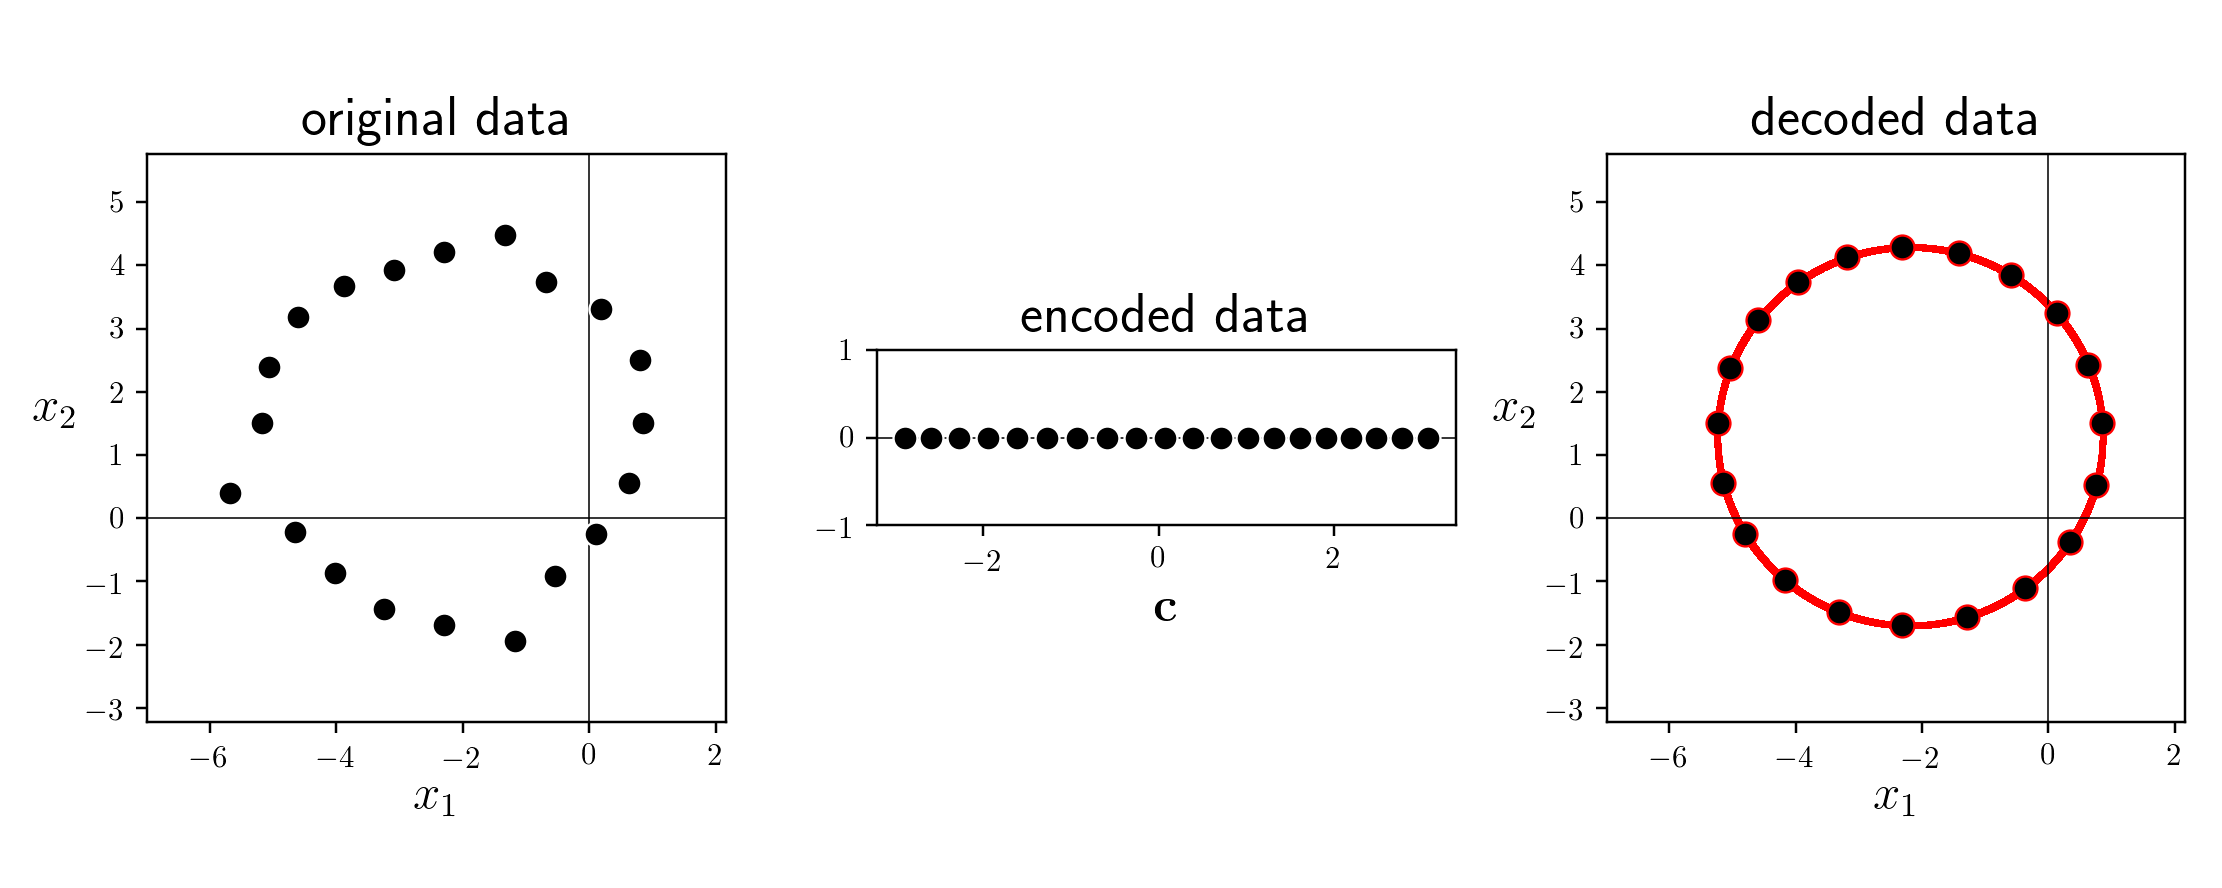

<IPython.core.display.Javascript object>


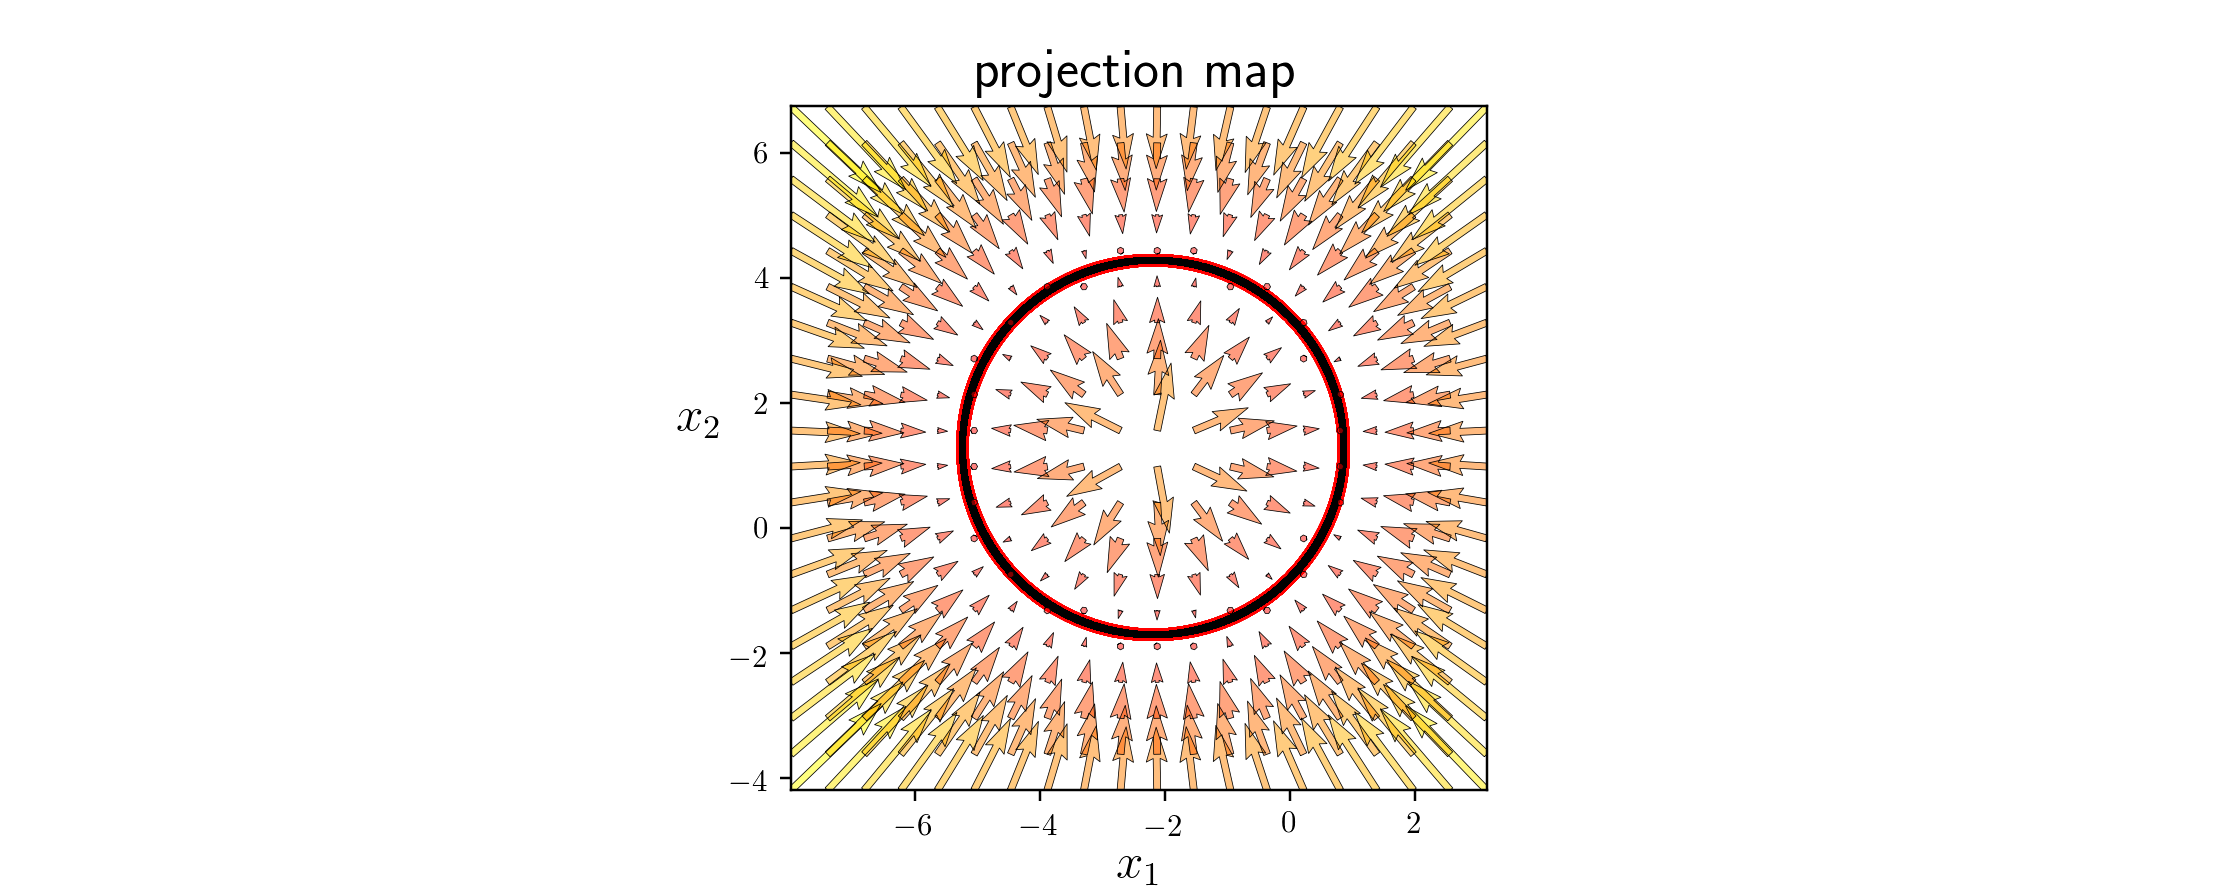

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# plot results
unlib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,encoder=encoder,decoder=decoder,show_pc = False,scale = 55,encode_label = r'$\mathbf{c}$',projmap = True)

## 10.5.4 Implementing nonlinear Autoencoder in `Python`

To implement the nonlinear Autoencoder in `Python` we can virtually re-use most of the code framework we employed in the linear case - including our `model` and `autoencoder` functions detailed in Section 8.3.  We only need to slightly modify the `model` function to take in a generally larger set of parameters - since each of our encoding/decoding functions can in general have unique sets of parameters. To keep things as general as possible we will rewrite the `model` function as shown below.  Note here we input $\Omega$ as a single list called `w` which contains two arrays: its first array `w[0]` contains the parameters of our encoder while the second array `w[1]` contains parameters of the decoder. The encoder and decoder's sets of parameters can be identical (as with the linear case discussed in the previous Subsection), partially overlap, or be completely disjoint.

In [8]:
# a general model wrapping up our encoder/decoder
def model(X,w):
    # encode the input
    v = encoder(X,w[0])
    
    # decode the encoding
    a = decoder(v,w[1])
    return a

Then since each of our `encoder` and `decoder` function can in general be a linear combination of feature transformations, each can be written in general precisely as we implemented a single such combination of features for e.g., regression or classification in the previous Sections.  For example, in general the `encoder` can be implemented as follows (and likewise for the general `decoder`).

In [2]:
# a generic encoder implementation
def encoder(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.